In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import LabelEncoder

import os
import argparse
import time
import warnings
import random

from copy import deepcopy
from box import Box
import bottleneck as bn

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# Define Data

In [10]:
class dataClass():
    def __init__(self, data_dir : str, min_user_cnt : int, min_movie_cnt : int, n_heldout : int, target_prop : float,
                 min_movie_to_split : int, ):
        '''
        data_dir : csv file 경로
        min_user_cnt : 영화 당 최소 유저 수, 5 = 영화를 본 유저 수가 5명 미만이면 제외
        min_movie_cnt : 유저 당 최소 영화 수, 5 = 영화를 5개 미만으로 본 유저는 제외
        n_heldout : evaluation user 및 test user의 수
        target_prop : 사용자가 본 영화중 target으로 사용할 영화의 비율
        min_movie_to_split : input, target split을 하기 위한 최소 영화 수
        '''
        
        # load data
        self.data_dir = data_dir
        self.raw_data = pd.read_csv(self.data_dir, header=0)
        
        # filtering data
        self.min_user_cnt = min_user_cnt
        self.min_movie_cnt = min_movie_cnt
        self.data, self.n_users_by_movie, self.n_movies_by_user = self._filter_triplets(self.raw_data)
        
        # unique users and movies
        self.users = np.unique(self.data['user'])
        self.n_users = len(self.users)
        self.movies = np.unique(self.data['item'])
        self.n_movies = len(self.movies)
        
        # user split and get data
        self.n_heldout = n_heldout
        self.train_users, self.valid_users, self.test_users = self._user_split()
        self.train_data, self.valid_data, self.test_data = self._get_data()
        
        # input_target split
        self.target_prop = target_prop
        self.min_movie_to_split = min_movie_to_split
        self.train_input = deepcopy(self.train_data)
        self.valid_input, self.valid_target = self._input_target_split(self.valid_data)
        self.test_input, self.test_target = self._input_target_split(self.test_data)
        
        # label encode
        for data in [self.train_input, self.valid_input, self.valid_target, self.test_input, self.test_target]:
            self.user_encoder, self.item_encoder = self._label_encode(data)
        
        # raw data to sparse matrix
        self.train_matrix = self._data_to_matrix('train')
        self.valid_matrix_input, self.valid_matrix_target = self._data_to_matrix('valid')
        self.test_matrix_input, self.test_matrix_target = self._data_to_matrix('test')

        # inference data
        self.inference_matrix = self._make_inference_dataset()
        
        self.datasets = {'train_data' : self.train_matrix,
                         'valid_data' : (self.valid_matrix_input, self.valid_matrix_target),
                         'test_data' : (self.test_matrix_input, self.test_matrix_target),
                         'inference_data' : self.inference_matrix}
        

        
        print('complete!')
        
    def _filter_triplets(self, raw_data) :

        print('filter min...')

        user_cnt = self._get_cnt(raw_data, 'user')
        raw_data = raw_data[raw_data['user'].isin(user_cnt.index[user_cnt >= self.min_user_cnt])]

        movie_cnt = self._get_cnt(raw_data, 'item')
        raw_data = raw_data[raw_data['item'].isin(movie_cnt.index[movie_cnt >= self.min_movie_cnt])]
                            
        return raw_data, movie_cnt, user_cnt
    
    def _get_cnt(self, raw_data, col):
        
        cnt_groupby_col = raw_data[[col]].groupby(col, as_index=False)
        cnt = cnt_groupby_col.size()
        
        return cnt
    
    def _user_split(self):
        
        print('user split...')
        np.random.seed(98765)
        i_shuffle = np.random.permutation(self.users.size)
        self.users = self.users[i_shuffle]
        
        train_users = self.users[:(self.n_users - self.n_heldout*2)]
        valid_users = self.users[(self.n_users - self.n_heldout*2) : (self.n_users - self.n_heldout)]
        test_users = self.users[(self.n_users - self.n_heldout) : ]
    
        return train_users, valid_users, test_users
    
    def _get_data(self):
        
        print('getting data...')
        train_data = self.data.loc[self.data['user'].isin(self.train_users)]
        self.train_movies = pd.unique(train_data['item'])
        
        valid_data = self.data.loc[self.data['user'].isin(self.valid_users)]
        valid_data = valid_data.loc[valid_data['item'].isin(self.train_movies)]
        
        test_data = self.data.loc[self.data['user'].isin(self.test_users)]
        test_data = test_data.loc[test_data['item'].isin(self.train_movies)]
        
        return train_data, valid_data, test_data
    
    def _input_target_split(self, data):
        
        print(f'input target split...')
        data_grby_user = data.groupby('user')
        input_list, target_list = list(), list()
        
        np.random.seed(98765)

        for _, group in data_grby_user :
            
            n_movies_of_user = len(group)
            
            if n_movies_of_user >= self.min_movie_to_split :
                
                index = np.zeros(n_movies_of_user, dtype='bool')
                index[np.random.choice(n_movies_of_user, size=int(self.target_prop * n_movies_of_user), replace=False).astype('int64')] = True
                
                input_list.append(group[np.logical_not(index)])
                target_list.append(group[index])
                
            else :
                input_list.append(group)
                
        input = pd.concat(input_list)
        target = pd.concat(target_list)
        
        return input, target
    
    def _label_encode(self, data) :
        
        print('encoding...')
        
        profile2id = dict((user, i) for (i, user) in enumerate(self.users))
        show2id = dict((movie, i) for (i, movie) in enumerate(self.train_movies))
        
        user_id = data['user'].apply(lambda x : profile2id[x])
        movie_id = data['item'].apply(lambda x : show2id[x])
        data['user'] = user_id
        data['item'] = movie_id
        
        return profile2id, show2id
    
    def _data_to_matrix(self, data_type) :
        
        if data_type == 'train':
            
            n_users = self.train_input['user'].max() + 1
            rows, cols = self.train_input['user'], self.train_input['item']
            matrix = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), 
                                     dtype='float64',
                                     shape=(n_users, self.n_movies))
            return matrix
        
        if data_type == 'valid':
            input = self.valid_input
            target = self.valid_target
        
        if data_type == 'test' :
            input = self.test_input
            target = self.test_target

        start_idx = min(input['user'].min(), target['user'].min())
        end_idx = max(input['user'].max(), target['user'].max())

        rows_input, cols_input = input['user'] - start_idx, input['item']
        rows_target, cols_target = target['user'] - start_idx, target['item']
        
        matrix_input = sparse.csr_matrix((np.ones_like(rows_input), (rows_input, cols_input)), 
                                         dtype='float64',
                                         shape=(end_idx - start_idx + 1, self.n_movies))
        
        matrix_target = sparse.csr_matrix((np.ones_like(rows_target),
                                       (rows_target, cols_target)), dtype='float64',
                                       shape=(end_idx - start_idx + 1, self.n_movies))
        
        return matrix_input, matrix_target
    
    def _make_inference_dataset(self) :
        data = self.data.drop('time', axis=1)
        self.user_encoder, self.item_encoder = self._label_encode(data)
        
        n_users = self.n_users
        rows, cols = data['user'], data['item']    
        matrix = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), 
                                 dtype='float64',
                                 shape=(n_users, self.n_movies))
        
        self.inference_data = data
        return matrix

# Define Model

In [3]:
class MultiVAE(nn.Module):

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])
        
        self.drop = nn.Dropout(dropout)
        self.init_weights()
    
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)
        
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:

                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

def loss_function_vae(recon_x, x, mu, logvar, anneal=1.0):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return BCE + anneal * KLD

# Define Trainer

In [4]:
class Trainer() :
    def __init__(self, model, optimizer, criterion, batch_size, epochs,
                 datasets : dict,
                 annealing_steps, anneal_cap,
                 ndcg_k, recall_k,
                 output_path, model_name, device,
                 user_encoder, item_encoder) :
        
        # basic learning and evaluating parameter
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.batch_size = batch_size
        self.epochs = epochs
        
        # datasets
        self.datasets = datasets
        self.train_data = self.datasets['train_data']
        self.valid_input, self.valid_target = self.datasets['valid_data']
        self.test_input, self.test_target = self.datasets['test_data']
        self.inference_data = self.datasets['inference_data']
        
        # annealing parameter
        self.annealing_steps = annealing_steps
        self.anneal_cap = anneal_cap
        self.update_count = 0
        
        # metric pararmeter
        self.ndcg_k = ndcg_k
        self.recall_k = recall_k
        
        # etc
        self.output_path = output_path
        self.model_name = model_name
        self.device = device
        
        # result
        self.train_loss_list = []
        self.eval_loss_list = []
        self.ndcg_list = []
        self.recall_list = []
        
        # inference
        self.user_encoder = user_encoder
        self.item_encoder = item_encoder 
        
    def train(self, verbose=True) :
        
        self.update_count = 0
        
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
            
        best_ndcg = 0
        best_recall = 0
        
        epoch_start = torch.cuda.Event(enable_timing=True)
        epoch_end = torch.cuda.Event(enable_timing=True)
        
        for epoch in range(self.epochs) :
            
            epoch_start.record()
            
            train_loss = self._train(self.train_data)
            eval_loss, ndcg, recall = self._eval(self.model, self.valid_input, self.valid_target)
            
            epoch_end.record()
            torch.cuda.synchronize()
            time = epoch_start.elapsed_time(epoch_end)/1000
            
            self.train_loss_list.append(train_loss)
            self.eval_loss_list.append(eval_loss)
            self.ndcg_list.append(ndcg)
            self.recall_list.append(recall)
            
            if verbose == True :
                print(f'[{epoch+1}/{self.epochs}] train_loss : {train_loss:.4f} || eval_loss : {eval_loss:.4f} || NDCG : {ndcg:.4f} || RECALL : {recall:.4f} || time : {time:.2f}s')
            
            if best_ndcg < ndcg :
                best_ndcg = ndcg
                self.ndcg_best_model = self.model
                torch.save(self.ndcg_best_model, os.path.join(self.output_path, f'Best_NDCG({self.ndcg_k})_{self.model_name}.pt'))
                print(f'Save(NDCG : {best_ndcg:.4f}) || epoch : {epoch})')
            
            if best_recall < recall :
                best_recall = recall
                self.recall_best_model = self.model
                torch.save(self.recall_best_model, os.path.join(self.output_path, f'Best_RECALL({self.recall_k})_{self.model_name}.pt'))
                print(f'Save(RECALL : {best_recall:.4f} || epoch : {epoch})')
    
    def test(self, metric) :
        if metric == 'recall':
            loss, ndcg, recall = self._eval(self.recall_best_model, self.test_input, self.test_target)
            print(f'[test] loss : {loss:.4f} || ndcg : {ndcg:.4f} || recall : {recall:.4f}')
        if metric == 'ndcg':
            loss, ndcg, recall = self._eval(self.ndcg_best_model, self.test_input, self.test_target)
            print(f'[test] loss : {loss:.4f} || ndcg : {ndcg:.4f} || recall : {recall:.4f}')
            
    
    ################################################# inner function ##################################################################
    def _train(self, input_data) :
        
        total_length = input_data.shape[0]
        shuffled_idx = list(range(total_length))
        n_batches = np.ceil(total_length / self.batch_size)
        np.random.shuffle(shuffled_idx)
        
        self.model.train()
        train_loss = 0.0

        for start_idx in range(0, total_length, self.batch_size):
            end_index = min(start_idx + self.batch_size, total_length)

            
            input_batch = input_data[shuffled_idx[start_idx:end_index]]
            input_batch = self._sparse2Tensor(input_batch).to(self.device)
            
            if self.annealing_steps > 0 : anneal = min(self.anneal_cap, 1. * self.update_count / self.annealing_steps)
            else : anneal = self.anneal_cap
            
            ###################TRAIN##################
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(input_batch)
            loss = self.criterion(recon_batch, input_batch, mu, logvar, anneal)
            loss.backward()
            train_loss += loss.item()
            self.update_count += 1
            self.optimizer.step()
            ##########################################

        epoch_loss = train_loss / n_batches
        
        return epoch_loss
    
    def _eval(self, model, input_data, target_data) :
        
        total_length = input_data.shape[0]
        eval_idx = list(range(total_length)) # == n_heldout
        n_batches = np.ceil(total_length / self.batch_size)

        ndcg_list = []
        recall_list = []
    
        self.model.eval()
        eval_loss = 0.0
        
        with torch.no_grad():
            for start_idx in range(0, total_length, self.batch_size):

                end_idx = min(start_idx + self.batch_size, total_length)
                idx = eval_idx[start_idx:end_idx]
                
                input_batch = input_data[idx]
                input_batch = self._sparse2Tensor(input_batch).to(self.device)
                target_batch = target_data[idx]
                
                anneal = min(self.anneal_cap, 1. * self.update_count / (self.annealing_steps + 1e-10))
                
                ######################EVALUATE#############################
                recon_batch, mu, logvar = model(input_batch)
                loss = self.criterion(recon_batch, input_batch, mu, logvar, anneal)
                eval_loss += loss.item()
                
                self.input_batch = input_batch # 확인용
                self.recon_batch = recon_batch # 확인용
                
                recon_batch[torch.nonzero(input_batch, as_tuple=True)] = -np.inf
                ndcg = self._get_NDCG(recon_batch, target_batch, self.ndcg_k)
                recall = self._get_RECALL(recon_batch, target_batch, self.recall_k)
                
                ndcg_list.extend(ndcg)
                recall_list.extend(recall)
                ###########################################################
            
        ndcg = np.mean(ndcg_list)
        recall = np.mean(recall_list)
        eval_loss /= n_batches
        
        return eval_loss, ndcg, recall
        
    def _sparse2Tensor(self, data) :
        
        return torch.FloatTensor(data.toarray())
    
    def _get_NDCG(self, recon_batch, target_batch, k) :
        
        recon_batch = recon_batch.cpu().numpy()
        
        batch_users = recon_batch.shape[0]
        idx_topk_part = bn.argpartition(-recon_batch, k, axis=1)
        topk_part = recon_batch[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:,:k]]
        idx_part = np.argsort(-topk_part, axis=1)
        idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
        tp = 1. / np.log2(np.arange(2, k+2))
        DCG = (target_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
        IDCG = np.array([(tp[:min(n, k)]).sum() for n in target_batch.getnnz(axis=1)])
        
        return DCG / IDCG
    
    def _get_RECALL(self, recon_batch, target_batch, k):
        
        recon_batch = recon_batch.cpu().numpy()
        
        batch_users = recon_batch.shape[0]
        idx = bn.argpartition(-recon_batch, k, axis=1)
        prediction = np.zeros_like(recon_batch, dtype=bool)
        prediction[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True
        
        real = (target_batch > 0).toarray()
        hit = (np.logical_and(prediction, real).sum(axis=1)).astype(np.float32)
        recall = hit / np.minimum(k, real.sum(axis=1))
        
        return recall

# Train

In [5]:
def setSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Use {device}')

dir_base = os.path.join(os.path.join('/opt','ml','input','data'))
dir_data = os.path.join(dir_base, 'train')
path_rating = os.path.join(dir_data, 'train_ratings.csv')
dir_output = os.path.join(os.getcwd(), 'output')
dir_file_path = {
    'dir_base': dir_base,
    'dir_data': dir_data,
    'rating': path_rating,
    'dir_output': dir_output,
}

config = {
    'seed' : 42,
    'device' : device
}

config = Box(config)

hyper = {
    'min_user_cnt' : 5,
    'min_movie_cnt' : 0,
    'n_heldout' : 3000,
    'target_prop' : 0.2,
    'min_movie_to_split' : 5,
    
    'p_dims' : [200, 600, 6807], # best = 150, 6807
    
    'batch_size' : 256,
    'epochs' : 100, # best 500
    'optimizer' : 'Adam',
    'criterion' : loss_function_vae,
    'annealing_steps' : 200000,
    'anneal_cap' : 0.2,
    'recall_k': 10,
    'ndcg_k' : 50,
    'dropout' : 0.5,
    'lr' : 1e-4,
    'wd' : 0.0
}


path = Box(dir_file_path)
config = Box(config)
hyper = Box(hyper)
setSeed(config.seed)

Use cuda


In [12]:
data = dataClass(data_dir=path.rating, 
                 min_user_cnt=hyper.min_user_cnt,
                 min_movie_cnt=hyper.min_movie_cnt,
                 n_heldout=hyper.n_heldout, 
                 target_prop=hyper.target_prop,
                 min_movie_to_split=hyper.min_movie_to_split)

filter min...
user split...
getting data...
input target split...
input target split...
encoding...
encoding...
encoding...
encoding...
encoding...
encoding...
complete!


In [ ]:
torch.cuda.empty_cache()

model = MultiVAE(p_dims=hyper.p_dims,
                 dropout=hyper.dropout).to(device)

optimizer = optim.Adam(model.parameters(),
                       lr=hyper.lr,
                       weight_decay=hyper.wd)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  criterion=hyper.criterion,
                  batch_size=hyper.batch_size,
                  epochs=hyper.epochs,
                  
                  datasets=data.datasets,
                  
                  annealing_steps=hyper.annealing_steps,
                  anneal_cap=hyper.anneal_cap,
                  
                  ndcg_k=hyper.ndcg_k,
                  recall_k=hyper.recall_k,
                  
                  output_path=path.dir_output,
                  model_name='MultiVAE',
                  device=device,
                  
                  user_encoder=data.user_encoder,
                  item_encoder=data.item_encoder
                 )

In [ ]:
trainer.train(verbose=True)
trainer.test(metric='recall')
trainer.test(metric='ndcg')

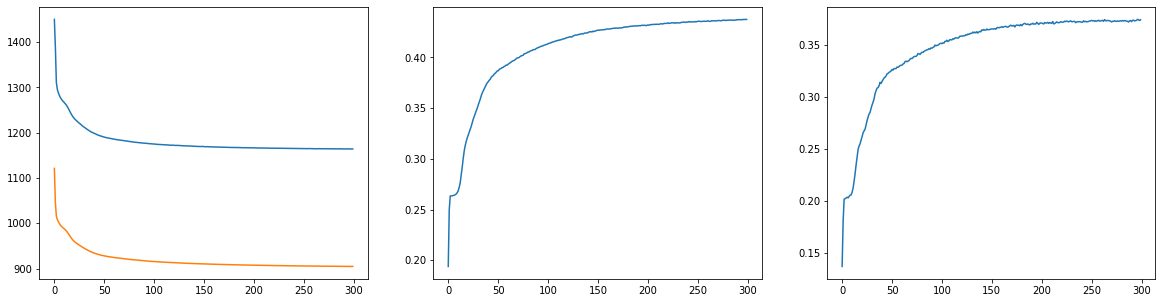

In [105]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.lineplot(x = range(len(trainer.train_loss_list)),
             y = trainer.train_loss_list,
             ax = axes[0])
sns.lineplot(x = range(len(trainer.eval_loss_list)),
             y = trainer.eval_loss_list,
             ax = axes[0])
sns.lineplot(x = range(len(trainer.ndcg_list)),
             y = trainer.ndcg_list,
             ax = axes[1])
sns.lineplot(x = range(len(trainer.recall_list)),
             y = trainer.recall_list,
             ax = axes[2])
plt.show()

# Inference 

In [106]:
def inference(trainer, data, k, metric):
    
    if metric == 'recall':
        model = trainer.recall_best_model
    if metric == 'ndcg':
        model = trainer.ndcg_best_model
        
    input_data = trainer.inference_data
    users = range(data.n_users)

    model.eval()
    with torch.no_grad():

        input_data = trainer._sparse2Tensor(input_data).to(trainer.device)
        prediction, _, _ = model(input_data)
        prediction[torch.nonzero(input_data, as_tuple=True)] = -np.inf
        scores, movies = torch.topk(prediction, dim=1, k=k)
        
        users = np.tile(users, (k,1)).T
        user_list = np.concatenate([user for user in users])
        score_list = torch.cat([score for score in scores])
        movie_list = torch.cat([movie for movie in movies])
    
    user_decoder = {value : key for (key, value) in trainer.user_encoder.items()}
    item_decoder = {value : key for (key, value) in trainer.item_encoder.items()}
    
    inference_df = pd.DataFrame()
    inference_df['user'] = user_list
    inference_df['item'] = movie_list.cpu().numpy()
    inference_df['score'] = score_list.cpu().numpy()
    
    inference_df['user'] = inference_df['user'].apply(lambda x : user_decoder[x])
    inference_df['item'] = inference_df['item'].apply(lambda x : item_decoder[x])

    return inference_df

In [107]:
inference_df = inference(trainer, data, k=6807, metric='ndcg')
inference_df = inference_df.sort_values(['user', 'score'], ascending=[True, False])

In [108]:
inference_df

,user,item,score
118250,11,4370,5.020717
118251,11,37386,4.542386
118252,11,3156,3.977032
118253,11,3986,3.764935
118254,11,2,3.725107
...,...,...,...
107835,138493,32587,3.317322
107836,138493,2012,3.305635
107837,138493,2628,3.289887
107838,138493,32,3.183196


In [115]:
inference_df[inference_df['user'] == data.users[7]]

,user,item,score
70,40424,2571,4.719611
71,40424,150,4.686028
72,40424,5952,4.633819
73,40424,1961,4.534969
74,40424,593,4.481285
75,40424,8961,4.436152
76,40424,260,4.401601
77,40424,2858,4.384027
78,40424,2324,4.377219
79,40424,2028,4.370713


In [62]:
SUB_PATH = '/opt/ml/input/code/notebook/Main/submission/'
inference_df.drop('score', axis=1, inplace=True)
i = 1
while True :
    if os.path.exists(os.path.join(SUB_PATH, f'VAE_{i}.csv')) :
        i += 1
        continue
    inference_df.to_csv(os.path.join(SUB_PATH, f'VAE_{i}.csv'), index=False)
    break